### Roadmap

* Generate CMB simulations based on the ideal Planck spectrum.
* Obtain the cosmic birefringence angle from each simulation (around 100-1000 simulations)
* Plot the distribution of the angle $\beta$ on a histogram
* Detect the STD of $\beta$ from the histogram
  
   -> For $D_\ell^{EB}$, $D_\ell^{TB}$ and the joint estimator $D_\ell^{EB+TB}$
* Compare STDs with the analytical results obtained in the thesis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
%matplotlib inline

In [23]:
#Planck fiducial power spectrum
l, TT, TE, EE, BB, PP = np.loadtxt('COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt',unpack=True)
l = l.astype(int)

In [24]:
nside = 512
lmin = 2
lmax = 2 * nside

# Creating an array of zeros
Cl_tt = np.zeros(lmax + 1)
Cl_ee = np.zeros(lmax + 1)
Cl_bb = np.zeros(lmax + 1)
Cl_te = np.zeros(lmax + 1)

# Setting limits on l and applying mask
mask = (l >= lmin) & (l <= lmax)
l_masked = l[mask]

# Conversion from Dl to Cl
factor = 2 * np.pi / (l_masked * (l_masked + 1))
Cl_TT_masked = TT[mask] * factor
Cl_EE_masked = EE[mask] * factor
Cl_BB_masked = BB[mask] * factor
Cl_TE_masked = TE[mask] * factor


Cl_tt[lmin:lmax + 1] = Cl_TT_masked
Cl_ee[lmin:lmax + 1] = Cl_EE_masked
Cl_bb[lmin:lmax + 1] = Cl_BB_masked
Cl_te[lmin:lmax + 1] = Cl_TE_masked

cls = [Cl_tt, Cl_ee, Cl_bb, Cl_te]

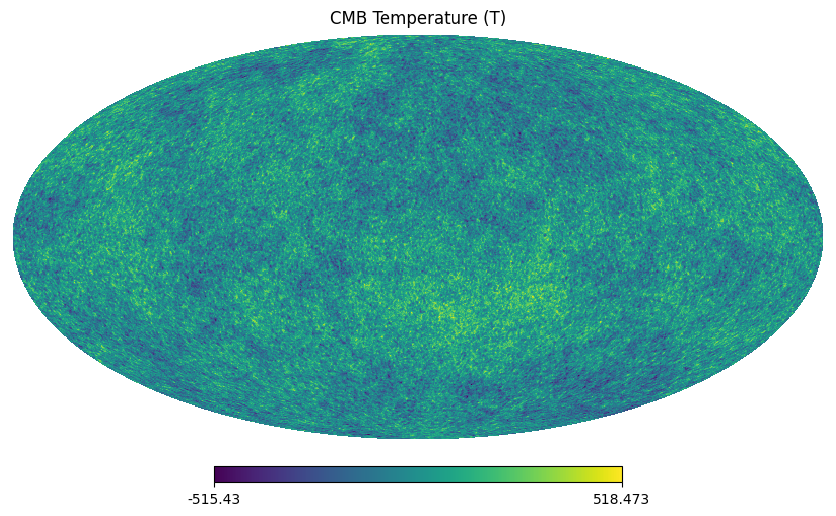

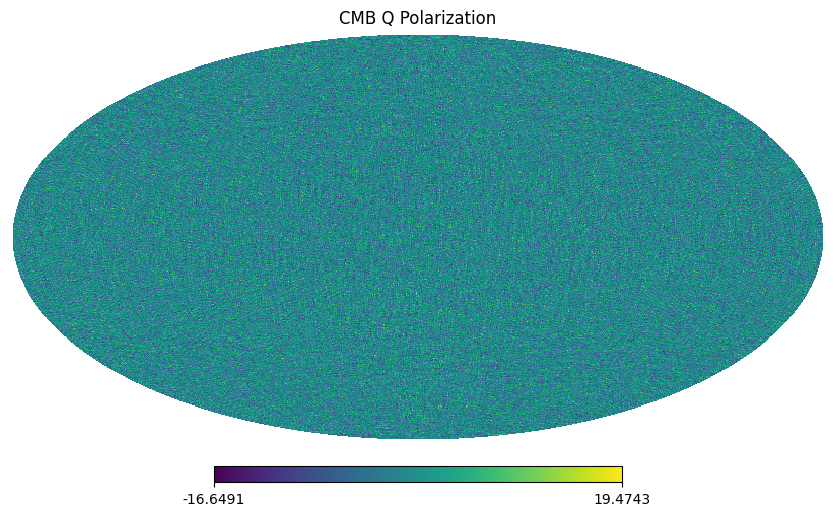

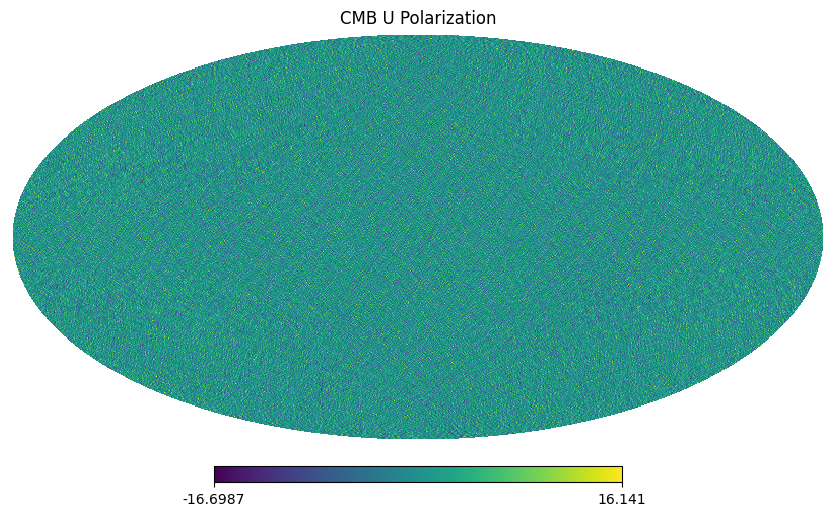

In [25]:
#Generating T, Q, U maps
TQU_map = hp.synfast(cls, nside=nside, lmax=lmax, pol=True, new=True)

# Plotting the maps
hp.mollview(TQU_map[0], title="CMB Temperature (T)")
hp.mollview(TQU_map[1], title="CMB Q Polarization")
hp.mollview(TQU_map[2], title="CMB U Polarization")
plt.show()


In [26]:
#Creating containers to store the simulated spectra
cls_TT, cls_EE, cls_BB = [], [], []
cls_TE, cls_TB, cls_EB = [], [], []

#Simulating the maps and computing the spectra
num_sims = 100
for i in range(num_sims):
    TQU_map = hp.synfast(cls, nside=nside, lmax=lmax, pol=True, new=True)
    cl = hp.anafast(TQU_map, lmax=lmax, pol=True)
    cls_TT.append(cl[0])
    cls_EE.append(cl[1])
    cls_BB.append(cl[2])
    cls_TE.append(cl[3])
    cls_TB.append(cl[4])
    cls_EB.append(cl[5])


In [27]:
#Lwt us now compute the mean & std:
def mean_and_err(arr):
    arr = np.array(arr)
    return np.mean(arr, axis=0), np.std(arr, axis=0, ddof=1) / np.sqrt(num_sims)

mean_TT, err_TT = mean_and_err(cls_TT)
mean_EE, err_EE = mean_and_err(cls_EE)
mean_BB, err_BB = mean_and_err(cls_BB)
mean_TE, err_TE = mean_and_err(cls_TE)
mean_TB, err_TB = mean_and_err(cls_TB)
mean_EB, err_EB = mean_and_err(cls_EB)

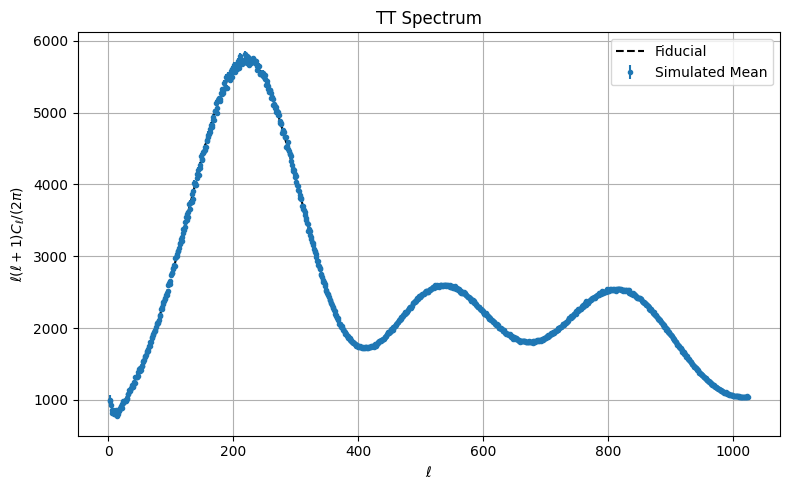

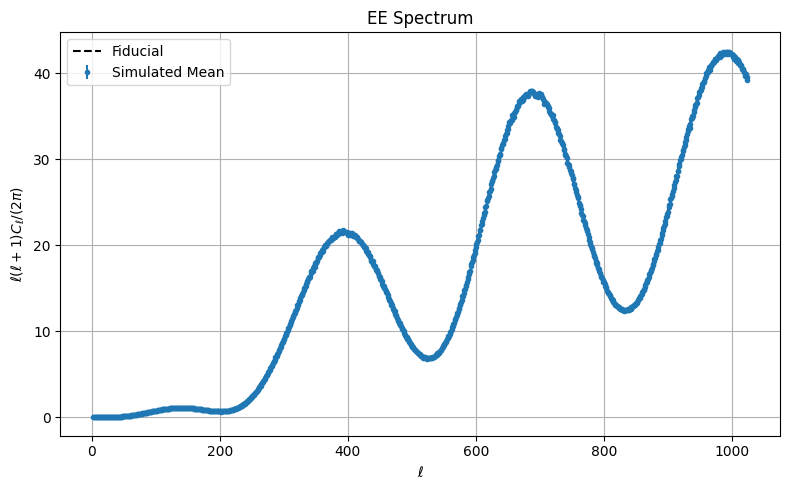

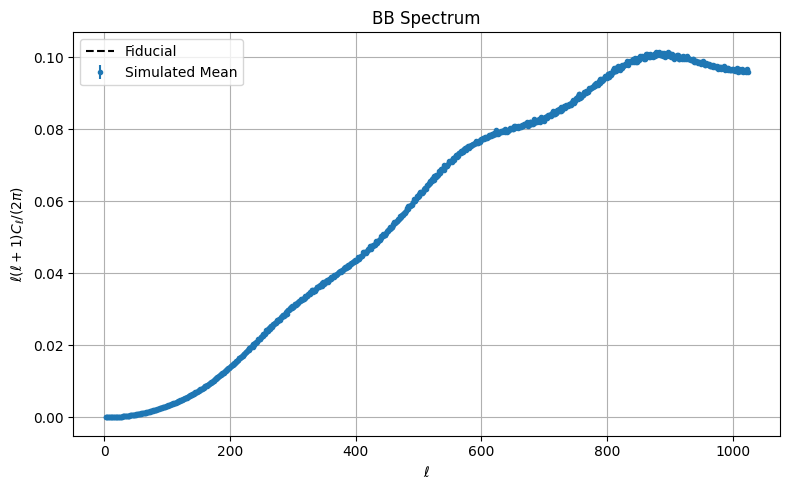

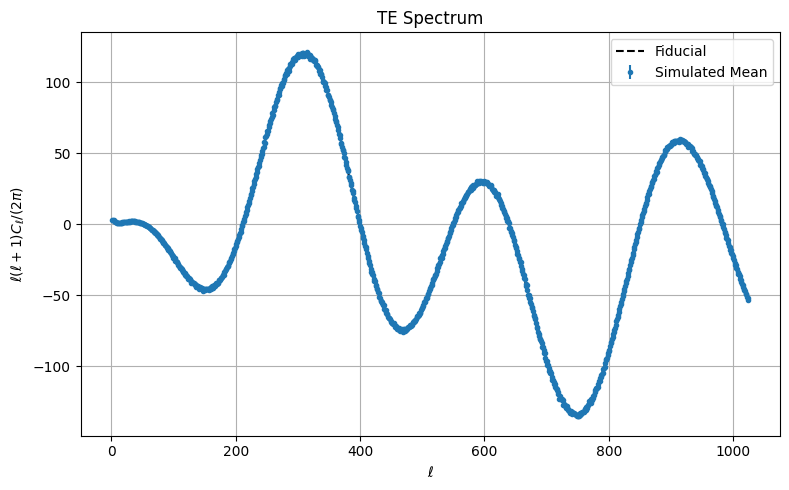

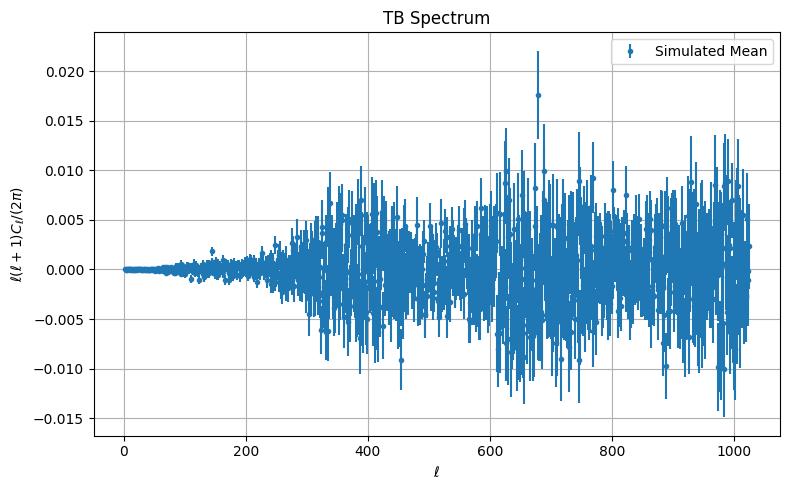

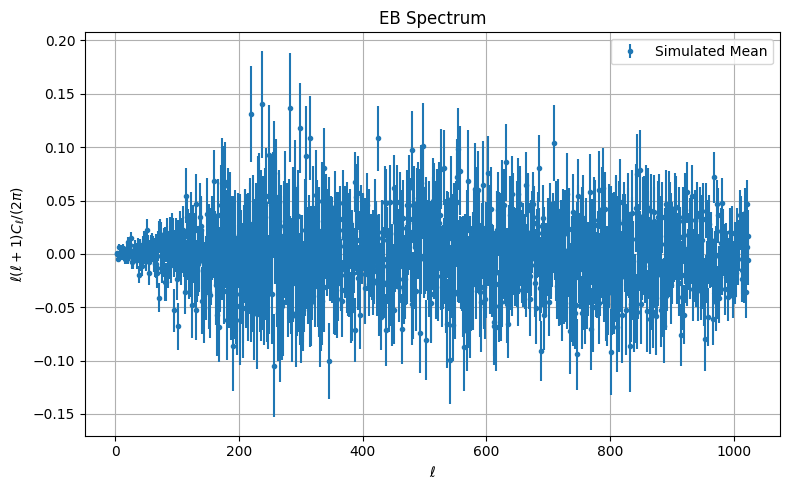

In [28]:
#Plotting the comparison between the fiducial spectra and the simulations:
l = np.arange(lmax + 1)

def plot_spectrum(l, mean, err, fid, label):
    plt.figure(figsize=(8,5))
    factor = l * (l + 1) / (2 * np.pi)
    plt.errorbar(l[2:], factor[2:] * mean[2:], factor[2:] * err[2:], fmt='.', label='Simulated Mean')
    if fid is not None:
        plt.plot(l[2:], factor[2:] * fid[2:], 'k--', label='Fiducial')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$')
    plt.title(f'{label} Spectrum')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


plot_spectrum(l, mean_TT, err_TT, Cl_tt, 'TT')
plot_spectrum(l, mean_EE, err_EE, Cl_ee, 'EE')
plot_spectrum(l, mean_BB, err_BB, Cl_bb, 'BB')
plot_spectrum(l, mean_TE, err_TE, Cl_te, 'TE')
plot_spectrum(l, mean_TB, err_TB, None, 'TB')
plot_spectrum(l, mean_EB, err_EB, None, 'EB')
